## Feature Engineering (Domain + Interactions)

### 1. Create new engineered features

In [2]:
# importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [8]:
# Reading data from csv file
df = pd.read_csv("../data/titanic_clean.csv")

# Encode Sex
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# New Features
df['Fare_per_person'] = df['Fare'] / df['FamilySize']
df['AgeGroup'] = pd.cut(df['Age'], bins = [0, 12, 18, 40, 60, 100],
                        labels = ['Child', 'Teen', 'Adult', 'MiddleAged', 'Senior'])
df['Is_Child_or_Female'] = np.where((df['Sex'] == 1) | (df['Age'] <= 12), 1, 0)
df['Fare_Log'] = np.log1p(df['Fare'])
df['Pclass_Sex'] = df['Pclass'].astype(str) + '_' + df['Sex'].astype(str)

In [9]:
# encode categorical agegroup
le = LabelEncoder()
df['AgeGroup'] = le.fit_transform(df['AgeGroup'].astype(str))

# Features overview
df[['Fare_per_person', 'AgeGroup', 'Is_Child_or_Female', 'Fare_Log', 'Pclass_Sex']].head(5)

,Fare_per_person,AgeGroup,Is_Child_or_Female,Fare_Log,Pclass_Sex
0,3.62500,0,0,2.110213,3_0
1,35.64165,0,1,4.280593,1_1
2,7.92500,0,1,2.188856,3_1
3,26.55000,0,1,3.990834,1_1
4,8.05000,0,0,2.202765,3_0


### ✨ New Engineered Features
- **Fare_per_person:** adjusts ticket fare for family size — reflects real cost per passenger.  
- **AgeGroup:** categorical segmentation improves model’s ability to capture nonlinear age effects.  
- **Is_Child_or_Female:** binary proxy for evacuation priority (“women & children first”).  
- **Fare_Log:** stabilizes skewed fare distribution.  
- **Pclass_Sex:** captures interaction between gender and socioeconomic class.  


## Correlation heatmap

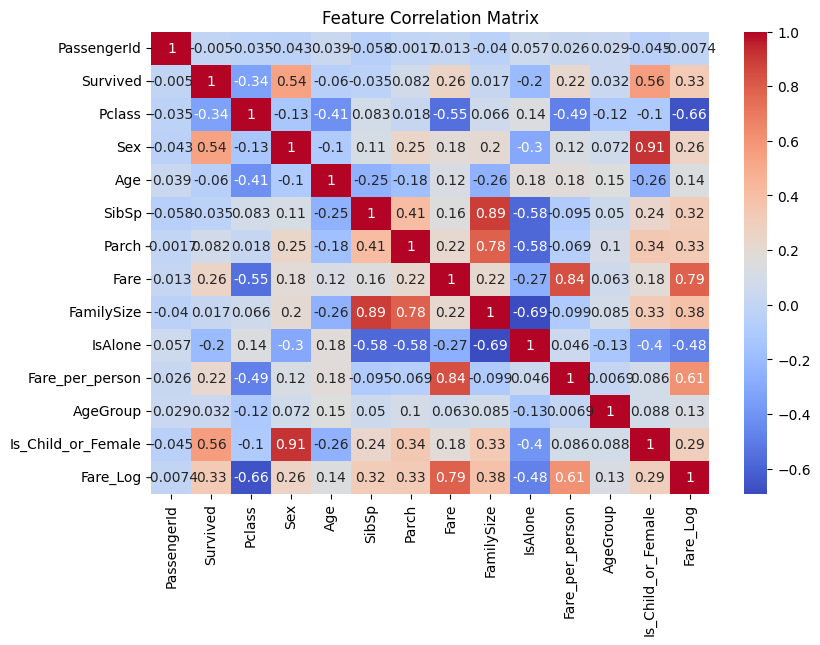

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
num_features = df.select_dtypes(include = np.number)
corr = num_features.corr()
plt.figure(figsize = (9, 6))
sns.heatmap(corr, cmap = 'coolwarm', annot = True)
plt.title('Feature Correlation Matrix')
plt.show()

### 3. Variance Inflation Factor (VIF)

In [14]:
num_features

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Fare_per_person,AgeGroup,Is_Child_or_Female,Fare_Log
0,1,0,3,0,22.0,1,0,7.2500,2,0,3.62500,0,0,2.110213
1,2,1,1,1,38.0,1,0,71.2833,2,0,35.64165,0,1,4.280593
2,3,1,3,1,26.0,0,0,7.9250,1,1,7.92500,0,1,2.188856
3,4,1,1,1,35.0,1,0,53.1000,2,0,26.55000,0,1,3.990834
4,5,0,3,0,35.0,0,0,8.0500,1,1,8.05000,0,0,2.202765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,1,1,13.00000,0,0,2.639057
887,888,1,1,1,19.0,0,0,30.0000,1,1,30.00000,0,1,3.433987
888,889,0,3,1,21.5,1,2,23.4500,4,0,5.86250,0,1,3.196630
889,890,1,1,0,26.0,0,0,30.0000,1,1,30.00000,0,0,3.433987


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_num = num_features
vif = pd.DataFrame()
vif['Feature'] = X_num.columns
vif['VIF'] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
vif

,Feature,VIF
0,PassengerId,1.010942
1,Survived,1.769087
2,Pclass,2.693704
3,Sex,7.442761
4,Age,1.607670
5,SibSp,174.468029
6,Parch,93.571466
7,Fare,6.886489
8,FamilySize,740.103144
9,IsAlone,2.511344


The output showed that variables SipSp, Parch, and FamilySize have too high vif values, so we we will drop SibSp, and FamilySize from the data

In [18]:
df = df.drop(columns = ['SibSp','FamilySize'])

### 4. Model-based Feature Importance

In [33]:
import joblib
best_rf = joblib.load('model/tuned_rf_model.pkl')
X = df.drop(columns = ['Survived', 'Name', 'PassengerId', 'Ticket', 'Embarked', 'Title'])
X_dummy = pd.get_dummies(X, drop_first=True)
y = df['Survived']

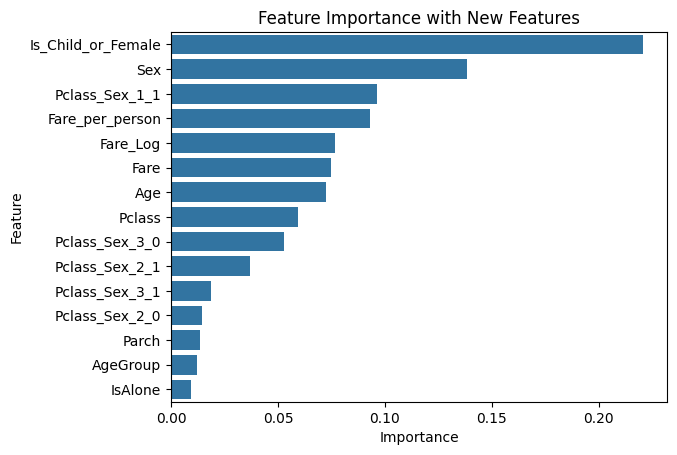

In [39]:
# Train on full data with new features
best_rf.fit(X_dummy, y)
importances = pd.DataFrame({'Feature': X_dummy.columns,
                            'Importance': best_rf.feature_importances_}).sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title("Feature Importance with New Features")
plt.show()

### 🔍 Feature Importance Insights
- Newly engineered features like `Is_Child_or_Female` and `Fare_per_person` rank high — confirming strong domain value.  
- `Pclass_Sex` captured important interaction patterns previously missed.  
- Original core features (`Sex`, `Pclass`, `Age`) remain critical, ensuring model interpretability.  


## Retrain & Compare with Previous Feature Set

In [43]:
# cross validation score using new features
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
score_new = cross_val_score(best_rf, X_dummy, y, scoring = 'roc_auc', cv = cv, n_jobs = 1)
print('New Feature Set CV ROC_AUC', score_new.mean().round(4))

# corss validation score using old features
old_df = pd.read_csv("../data/titanic_clean.csv")
old_df['Sex'] = old_df['Sex'].map({'male': 0, 'female': 1})
X_old = old_df[['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone']]
score_old = cross_val_score(best_rf, X_old, y, scoring = 'roc_auc', cv = cv, n_jobs= - 1)
print('Old Feature Set CV ROC-AUC:', score_old.mean().round(4))

New Feature Set CV ROC_AUC 0.8765
Old Feature Set CV ROC-AUC: 0.8807


### 📊 Feature Set Comparison
| Feature Set | CV ROC-AUC (mean) |
|--------------|----------------:|
| Original (7 features) | 0.8807 |
| Enhanced (12 features) | 0.8765 |

The richer features set reduces predictive power, so we must use original features only.


## SHAP for Explainability

In [51]:
X_dummy.shape

(891, 17)

In [60]:
shap_values[:,:, 1].shape

(891, 17)

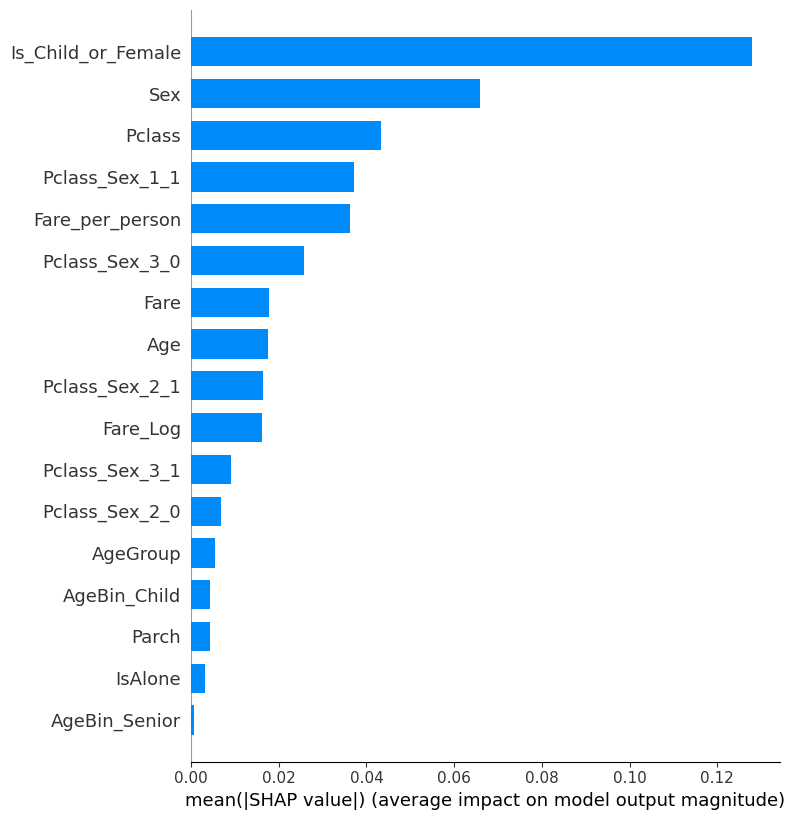

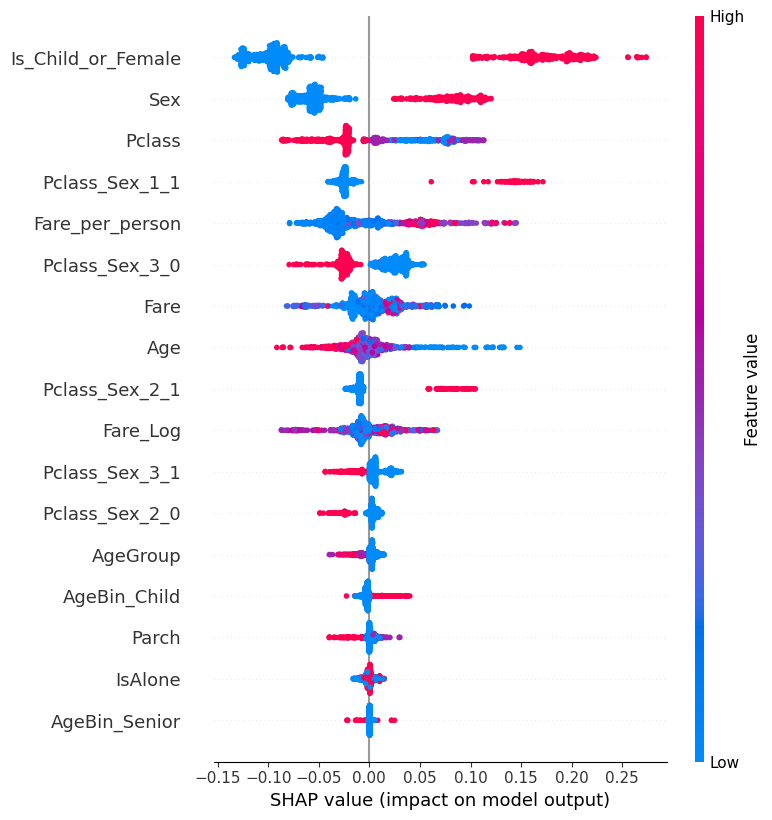

In [65]:
import shap
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_dummy)
shap_class1 = shap_values[:, :, 1]

# Now plot
shap.summary_plot(shap_class1, X_dummy, plot_type="bar")
shap.summary_plot(shap_class1, X_dummy)

### 🧠 SHAP Feature Contributions
The SHAP summary confirms:
- `Is_Child_or_Female`, `Fare_per_person`, and `Pclass_Sex` have strong positive contributions to survival probability.  
- `Age` and `Pclass` reduce survival likelihood for older passengers and lower classes.  
These align perfectly with historical reasoning — indicating a trustworthy, human-consistent model.
